# Language Model Distillation

<img src="https://arxiv.org/html/2402.13116v3/x2.png" width=600>

Model Distillation is the process of using a large foundation model/high parameter LLMs to create annotated data for a specific task. That data is then used to fine tune a lightweight language model on the same task, allowing the smaller parameter model to perform as well as the foundation model at a fraction of the cost, energy consumption, and time. 

Per the paper [A Survey on Knowledge Distillation of Large Language Models](https://arxiv.org/pdf/2402.13116), "This process is akin to transferring the ‘knowledge’ of a highly skilled teacher to a student, wherein the student (e.g., open-source LLM) learns to mimic the performance characteristics of the teacher (e.g., proprietary LLM)."

Most tasks that LLMs are applied to don't utilize the entire capability and power of a full size foundation model, so *why not distill down your one specific application into its own model?*

**In this notebook we'll be:**
1. Using [Llama 3.1 405B](https://huggingface.co/meta-llama/Meta-Llama-3.1-405B) to classify the sentiment of tweets, and
2. Use that dataset to train the GPT-2 125 million parameter language model we trained earlier in the process. 

We end up with a model that performs with the same accuracy, at 0.03% of the size!

---
# Teacher Model Data Annotation

Dataset consists of tweets with labeled sentiments, [mteb/tweet_sentiment_extraction](https://huggingface.co/datasets/mteb/tweet_sentiment_extraction). We will be using the tweet texts along with prompting to generate the "knowledge" annotation. This data is what becomes the training data for distillation.

This would become simply fine-tuning/model training if the data is not generated by an LLM teacher! (i.e. human annotated data)

For the sake of demonstration, assuming this data is not annoted already.

### Importing Existing Dataset

In [1]:
from datasets import load_dataset

ds = load_dataset("mteb/tweet_sentiment_extraction")

c:\Users\ethan_q18d778\Desktop\GPT2\GPT2-custom\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ethan_q18d778\Desktop\GPT2\GPT2-custom\myenv\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ethan_q18d778\.cache\huggingface\hub\datasets--mteb--tweet_sentiment_extraction. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to r

In [2]:
ds['train'][0]

{'id': 'cb774db0d1',
 'text': ' I`d have responded, if I were going',
 'label': 1,
 'label_text': 'neutral'}

### Creating CSV

Converting a subset to a local csv for easy manipulation and sampling.

Train/split subset via HuggingFace dataset available [AdamLucek/twittersentiment-llama-3.1-405B-labels](https://huggingface.co/datasets/AdamLucek/twittersentiment-llama-3.1-405B-labels)

In [7]:
import csv
import os

def convert_to_csv(ds, start_index, end_index, output_folder):

    output_file = os.path.join(output_folder, f"twittersentiment_{start_index}_{end_index}.csv")
    
    with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['id', 'text', 'label', 'label_text']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        writer.writeheader()
        for i in range(start_index, min(end_index, len(ds['train']))):
            row = ds['train'][i]
            writer.writerow(row)
    
    print(f"CSV file created: {output_file}")

# Usage
start_index = 7101
end_index = 7200
output_folder = "tweet_data/"
convert_to_csv(ds, start_index, end_index, output_folder)

CSV file created: tweet_data/twittersentiment_7101_7200.csv


### Cleaning the CSV

Simple script for dropping blank values that may break processing later on

In [17]:
# Load the CSV file
import pandas as pd
unclean_df = pd.read_csv("tweet_data/twittersentiment_7101_7200.csv")

# Remove rows where the 'text' label is blank
df_cleaned = unclean_df[unclean_df['text'].notna() & (unclean_df['text'].str.strip() != '')]

# Save the cleaned DataFrame to a new CSV file
df_cleaned.to_csv('tweet_data/twittersentiment_5001_6000_cleaned.csv', index=False)

---
# Setting Up Teacher LLM 

[Llama 3.1 405B](https://ai.meta.com/blog/meta-llama-3-1/) explicitly states that *Our new model will enable the community to unlock new workflows, such as synthetic data generation and model distillation* in Meta's [release blog](https://ai.meta.com/blog/meta-llama-3-1/), so I wanted to use it as an example for distillation on this task, thus Llama 3.1 405B becomes the teacher model.

The cheapest inference API i could find is via [Fireworks.ai](https://fireworks.ai/) which, at the time of making this, offer 1M Token `Input/Output` at `$3/$3` respectively. We'll use their integration with LangChain to instantiate.

In [177]:
from langchain_fireworks import ChatFireworks

llama_405B = ChatFireworks(
    model="accounts/fireworks/models/llama-v3p1-405b-instruct",
    temperature=0.7
)

### Prompting

To ensure we give our teacher model the best opportunity, we'll be employing two techniques in our classification prompt:
1. **Chain-of-Thought Reasoning:** Making the language model write a reasoning description to "think" through the problem before giving an answer
2. **Few-shot Prompting:** Providing robust examples about your expectations of both performance and format to better guide the LLM.

Examples taken from entries within the rows 7101-7200, which will not be used during training or for testing further on

In [58]:
tweet_sentiment_cot_prompt = """\
You are a highly qualified expert trained to annotate machine learning training data.
Your task is to briefly analyze the sentiment in the TEXT below from an social media manager perspective and then label it with only one the three labels:
positive, negative, neutral.
Base your label decision only on the TEXT and do not speculate e.g. based on prior knowledge about the context. 
You first reason step by step about the correct label and then return your label.
You ALWAYS respond once in the following JSON format with brackets: {{"reason": "...", "label": "..."}}

Examples:
Text: Mode: Home Office
JSON: {{"reason": "The text is a factual statement about a work mode without expressing any emotion or opinion", "label": "neutral"}}
Text: oh oh oh are you offering to send ducks! I love love love confit duck
JSON: {{"reason": "The text expresses enthusiasm and love for confit duck, indicating a positive sentiment", "label": "positive"}}
Text: off to glue stuff onto poster
JSON: {{"reason": "The text is a simple statement of an action without any emotional context", "label": "neutral"}}
Text: Beautiful Day..takn it down twitters tell ALL mothers Happy Mothers Day
JSON: {{"reason": "The text describes a beautiful day and expresses positive wishes for Mother's Day", "label": "positive"}}
Text: Likewise. However, what was the comment about originally?
JSON: {{"reason": "The text is a neutral inquiry without expressing any particular sentiment", "label": "neutral"}}
Text: wished didnt spend money last night
JSON: {{"reason": "The text expresses regret about spending money, indicating a negative sentiment", "label": "negative"}}
Text: yo wake your **** up and go to work go get that paper u aint sick dont lie
JSON: {{"reason": "The text is aggressive and accusatory, suggesting a negative sentiment", "label": "negative"}}
Text: Such a beautiful morning
JSON: {{"reason": "The text expresses appreciation for the morning, indicating a positive sentiment", "label": "positive"}}
Text: Nooo...i forgot my calculator for physics oh well class is allmost over :3
JSON: {{"reason": "The text expresses initial disappointment about forgetting a calculator, indicating a negative sentiment", "label": "negative"}}
"""

and converting to an invokable chain via LangChain

In [59]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system", tweet_sentiment_cot_prompt
        ),
        (
            "human", "Your TEXT to analyse: {text}"
        )
    ]
)

chain = prompt | llama_405B | JsonOutputParser()

In [161]:
# Example
response = chain.invoke("Want to get a Blackberry but can`t afford it. Just watching the telly and relaxing. Hard sesion tomorrow.")
response

{'reason': 'The text expresses a desire for a Blackberry but states an inability to afford it, which is a negative sentiment. However, the majority of the text describes a neutral, relaxing activity and mentions a hard session tomorrow without expressing any emotion about it. The overall tone is more neutral than negative, as the negative sentiment is brief and not emphasized.',
 'label': 'neutral'}

### Annotation Script

Now using our model + prompt to generate the annotations and combine them with the CSV. Error handling is generally due to the filtering that Llama 3.1 405B has to not generate answers when presented with innapropriate content.

**NOTE:** This is roughly ~$10 of usage via API when ran over 5,000 examples. Run with caution!

In [ ]:
import json

def process_csv(input_file, output_file):
    i = 0
    with open(input_file, 'r', newline='', encoding='utf-8') as infile, \
         open(output_file, 'w', newline='', encoding='utf-8') as outfile:
        
        reader = csv.DictReader(infile)
        fieldnames = reader.fieldnames + ['Llama_405B_reason', 'Llama_405B_label']
        
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        writer.writeheader()
        
        for row in reader:
            try:
                # Invoke the chain with the text from the current row
                response = chain.invoke({"text": row['text']})
                result = json.loads(response) if isinstance(response, str) else response
                
                # Add new fields to the row
                row['Llama_405B_reason'] = result['reason']
                row['Llama_405B_label_text'] = result['label']
                
                # Write the updated row to the output file immediately
                writer.writerow(row)
                
                # Flush the write buffer to ensure data is written to disk
                outfile.flush()
                
                i+=1
                print(f"{i} - Processed and saved row with id: {row['id']}")
            
            except Exception as e:
                # Error handling
                print(f"Error processing row with id {row.get('id', 'unknown')}: {str(e)}")
                continue

    print(f"Processing completed. Output saved to: {output_file}")

# Usage
input_file = "/Users/alucek/Documents/Jupyter_Notebooks/synthetic_data/tweet_sentiment/twittersentiment_5001_6000_cleaned.csv"
output_file = "/Users/alucek/Documents/Jupyter_Notebooks/synthetic_data/tweet_sentiment/test.csv"

process_csv(input_file, output_file)

### Calculate a Target Accuracy

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} \times100
$$

Calculating a base accuracy of Llama 3.1 405B vs the expectation from the dataset's labels gives us a target accuracy to aim for when training our student language model

In [19]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Load your updated CSV file
df = pd.read_csv('tweet_data/total_tests.csv')

# Calculate accuracy
accuracy = accuracy_score(df['label'], df['Llama_405B_label'])

print(f"Accuracy of Llama 3.1 405B: {accuracy:.2%}")

Accuracy of Llama 3.1 405B: 65.49%


---
# Training Student Model

Our student model will be [GPT-2]), a 125 million parameter language model. We'll be fine tuning this model on our Llama 3.1 405B annotated data using [AutoTrain Adance](https://github.com/huggingface/autotrain-advanced), HuggingFaces' packaged opensource solution for lowcode model training. They make it as easy as possible to run on local hardware, or via GPU accelerator platforms like Google's Colab or [HuggingFace Spaces](https://huggingface.co/autotrain).

We'll be using the *train* segment of the annotations generated, specifically the text from the original tweets and label as the Llama 3.1 405B generated label, passing in these hyperparameters (AutoTrain format)

```python
{
  "auto_find_batch_size": "false",
  "eval_strategy": "epoch",
  "mixed_precision": "fp16",
  "optimizer": "adamw_torch",
  "scheduler": "linear",
  "batch_size": "16",
  "early_stopping_patience": "5",
  "early_stopping_threshold": "0.01",
  "epochs": "5",
  "gradient_accumulation": "1",
  "lr": "0.00005",
  "logging_steps": "-1",
  "max_grad_norm": "1",
  "max_seq_length": "128",
  "save_total_limit": "1",
  "seed": "42",
  "warmup_ratio": "0.1",
  "weight_decay": "0"
}
```

Final trained model published at [AdamLucek/roberta-llama3.1405B-twitter-sentiment](https://huggingface.co/AdamLucek/roberta-llama3.1405B-twitter-sentiment)

---
# Testing Out the Fine Tuned Model

We'll be using [HuggingFace's Transformers Package Pipelines](https://huggingface.co/docs/transformers/en/main_classes/pipelines) to easily load and run inference using our trained model

In [22]:
from transformers import pipeline

# Create sentiment Analysis pipeline
# classifier = pipeline("sentiment-analysis", model="AdamLucek/roberta-llama3.1405B-twitter-sentiment")

KeyboardInterrupt: 

In [ ]:
# classifier("Want to get a Blackberry but can`t afford it. Just watching the telly and relaxing. Hard sesion tomorrow.")

[{'label': 'neutral', 'score': 0.40001702308654785}]

---
# Visualizing Accuracy

Now to calculate and compare our fine tuned model's accuracy to compare to LLama 3.1 405B. For fun, also ran tests using [GPT-4o-Mini](https://openai.com/index/gpt-4o-mini-advancing-cost-efficient-intelligence/) and a [generalized multilingual sentiment model of similar size](https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student).

In [23]:
# Calculate accuracy
result_df = pd.read_csv("tweet_data/total_tests.csv")

llama31_405B_accuracy = accuracy_score(result_df['label_text'], result_df['Llama_405B_label_text'])
gpt4omini_accuracy = accuracy_score(result_df['label_text'], result_df['GPT4o_mini_label'])
ft_roberta = accuracy_score(result_df['label_text'], result_df['Roberta_FT'])
multilingual = accuracy_score(result_df['label_text'], result_df['ML_Roberta'])

### Accuracy Graph

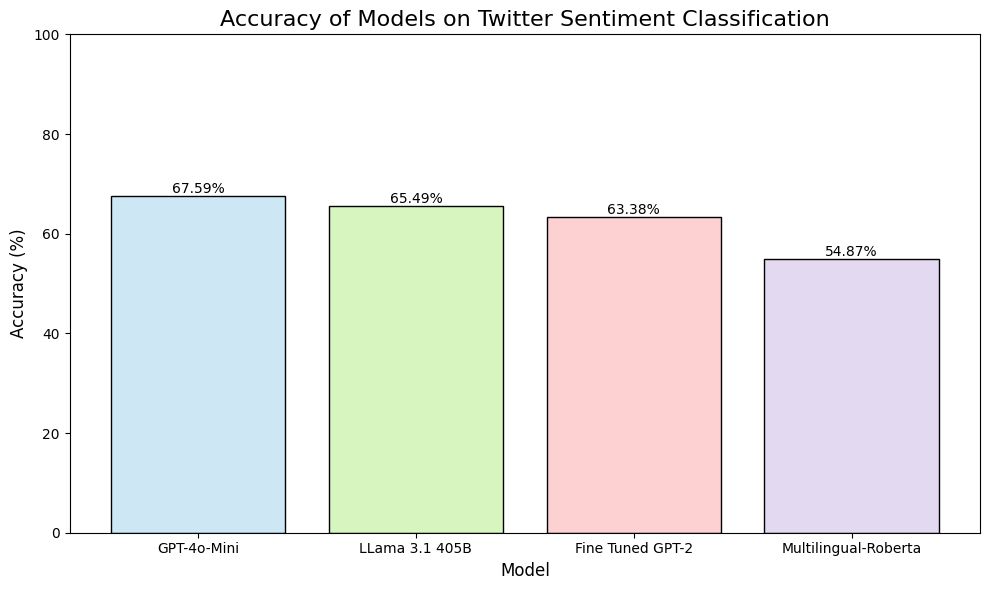

In [ ]:
import matplotlib.pyplot as plt

# Data
models = ['LLama 3.1 405B', 'GPT-4o-Mini', 'Custom GPT-2 ', 'Fine-tuned custom GPT-2']
accuracies = [llama31_405B_accuracy, gpt4omini_accuracy, multilingual, ft_roberta]

# Convert accuracies to percentages
percentages = [acc * 100 for acc in accuracies]

# Combine models and percentages into a list of tuples, sort by accuracy in descending order
sorted_data = sorted(zip(models, percentages), key=lambda x: x[1], reverse=True)
sorted_models, sorted_percentages = zip(*sorted_data)

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_models, sorted_percentages, color=['#cde8f4', '#d6f5bf', '#fdd1d1', '#e3d9f0'], edgecolor='black', linewidth=1)
plt.title("Accuracy of Models on Twitter Sentiment Classification", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.ylim(0, 100)  # Set y-axis range from 0 to 100%

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{height:.2f}%',
             ha='center', va='bottom')

# Display
plt.savefig("plot.png", dpi=300, bbox_inches="tight")  # High-quality save
plt.tight_layout()
plt.show()

Roughly the same performance at **0.03%** the size!

### Count of Sentiments

Also interesting to consider the distribution of sentiment labels across these models

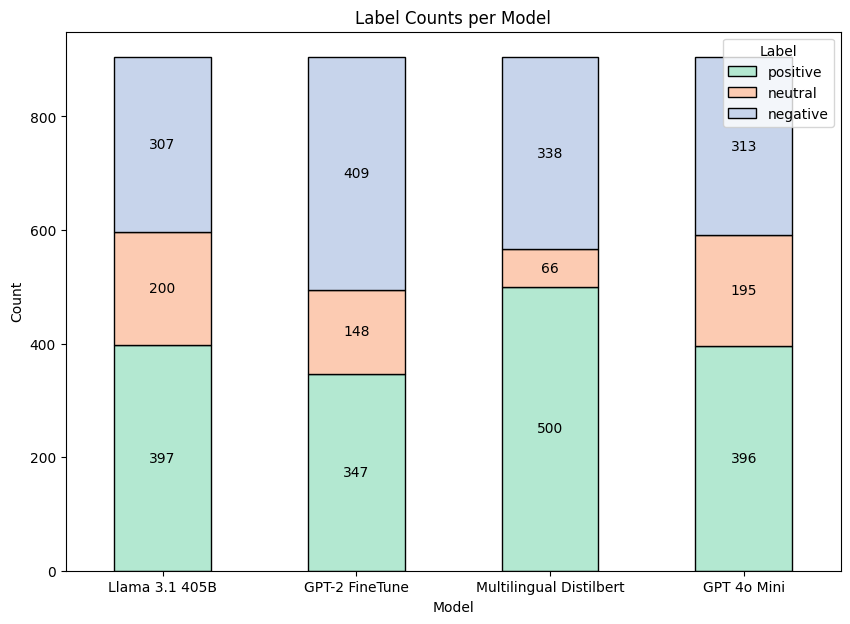

In [26]:
# List of models and their corresponding label columns
models = {
    'Llama 3.1 405B': 'Llama_405B_label_text',
    'GPT-2 FineTune': 'Roberta_FT',
    'Multilingual Distilbert': 'ML_Roberta',
    'GPT 4o Mini': 'GPT4o_mini_label'
}

# Calculating counts
label_counts = {model: {'positive': 0, 'neutral': 0, 'negative': 0} for model in models.keys()}
for model, column in models.items():
    label_counts[model]['positive'] = result_df[result_df[column] == 'positive'].shape[0]
    label_counts[model]['neutral'] = result_df[result_df[column] == 'neutral'].shape[0]
    label_counts[model]['negative'] = result_df[result_df[column] == 'negative'].shape[0]

# Create a DataFrame for plotting
counts_df = pd.DataFrame(label_counts).T

# Plotting with outlines
ax = counts_df.plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 7), 
    color=['#b3e8d1', '#fccbb2', '#c7d4eb'],
    edgecolor='black'
)

# Add counts on the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width/2, 
            y + height/2, 
            f'{int(height)}', 
            ha='center', 
            va='center')

plt.title('Label Counts per Model')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Label')
plt.show()

---
# Addtional Notes: 


Consider the costs:
* ~\$0.08 for gpt4o via OpenAI
* ~$1.80 for Llama 3.1 405B via Fireworks

And consider the time cost too! Much slower inference with the foundational models compared to the distilled language model.

Note that we are not aiming for higher accuracy here, rather a standard metric to assess our fine tuned model to see if it performs now as well as the foundation model

And a big shoutout to Moritz Laurer for the https://huggingface.co/blog/synthetic-data-save-costs blog, much of which the primary methodology that guided this notebook was heavily inspired by.